In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
from counterfactuals.datasets import HelocDataset
from counterfactuals.discriminative_models import MultilayerPerceptron

In [3]:
dataset = HelocDataset("../data/heloc.csv", shuffle=False)

In [4]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [128, 128], 2, dropout=0.2)
disc_model.fit(
    dataset.train_dataloader(batch_size=128, shuffle=True),
    dataset.test_dataloader(batch_size=128, shuffle=False),
    epochs=500,
    patience=100,
    lr=1e-3,
    checkpoint_path="disc_model.pt",
)
# disc_model.load("heloc_disc_model.pt")
disc_model.eval()

  0%|          | 0/500 [00:00<?, ?it/s]/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to th

MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=23, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (final_activation): Softmax(dim=1)
  (criterion): CrossEntropyLoss()
)

In [5]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
y_train_pred = disc_model.predict(dataset.X_train).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.7407594936708861


In [12]:
from counterfactuals.cf_methods.ares import AReS
from counterfactuals.cf_methods.globe_ce import GLOBE_CE

In [7]:
from sklearn.preprocessing import LabelEncoder


def one_hot(dataset, data):
    """
    Improvised method for one-hot encoding the data

    Input: data (whole dataset)
    Outputs: data_oh (one-hot encoded data)
             features (list of feature values after one-hot encoding)
    """
    label_encoder = LabelEncoder()
    data_encode = data.copy()
    dataset.bins = {}
    dataset.bins_tree = {}
    dataset.features_tree = {}
    dataset.n_bins = None

    # Assign encoded features to one hot columns
    data_oh, features = [], []
    for x in data.columns:
        dataset.features_tree[x] = []
        categorical = x in dataset.categorical_features
        if categorical:
            data_encode[x] = label_encoder.fit_transform(data_encode[x])
            cols = label_encoder.classes_
        elif dataset.n_bins is not None:
            data_encode[x] = pd.cut(
                data_encode[x].apply(lambda x: float(x)), bins=dataset.n_bins
            )
            cols = data_encode[x].cat.categories
            dataset.bins_tree[x] = {}
        else:
            data_oh.append(data[x])
            features.append(x)
            continue

        one_hot = pd.get_dummies(data_encode[x])
        data_oh.append(one_hot)
        for col in cols:
            feature_value = x + " = " + str(col)
            features.append(feature_value)
            dataset.features_tree[x].append(feature_value)
            if not categorical:
                dataset.bins[feature_value] = col.mid
                dataset.bins_tree[x][feature_value] = col.mid

    data_oh = pd.concat(data_oh, axis=1, ignore_index=True)
    data_oh.columns = features
    return data_oh, features

In [8]:
dataset_for_ares = HelocDataset("../data/heloc.csv", transform=False, shuffle=False)
data_oh, features = one_hot(
    dataset_for_ares,
    pd.DataFrame(dataset_for_ares.X_train, columns=dataset_for_ares.features[:-1]),
)

In [9]:
def predict_fn(x):
    x_scaled = dataset.feature_transformer.transform(x)
    return disc_model.predict(x_scaled).detach().numpy().flatten()

In [10]:
dataset_for_ares.X_test.shape

(1975, 23)

In [11]:
ares = AReS(
    predict_fn=predict_fn,
    dataset=dataset_for_ares,
    X=pd.DataFrame(dataset_for_ares.X_test, columns=dataset_for_ares.features[:-1]),
    dropped_features=[],
    n_bins=10,
    ordinal_features=[],
    normalise=False,
    constraints=[20, 7, 10],
)
bin_widths = ares.bin_widths

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [17]:
globe_ce = GLOBE_CE(
    predict_fn=predict_fn,
    dataset=dataset_for_ares,
    X=pd.DataFrame(dataset_for_ares.X_test, columns=dataset_for_ares.features[:-1]),
    bin_widths=bin_widths,
)

/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/cf_methods/globe_ce/globe_ce.py:519: DeprecationWarning: invalid escape sequence '\%'
  print("& {}\% & {} & {}\% & {}\\\\\\midrule".format(new_accs, new_costs,
/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


100%|██████████| 1000/1000 [00:00<00:00, 1600.22it/s]


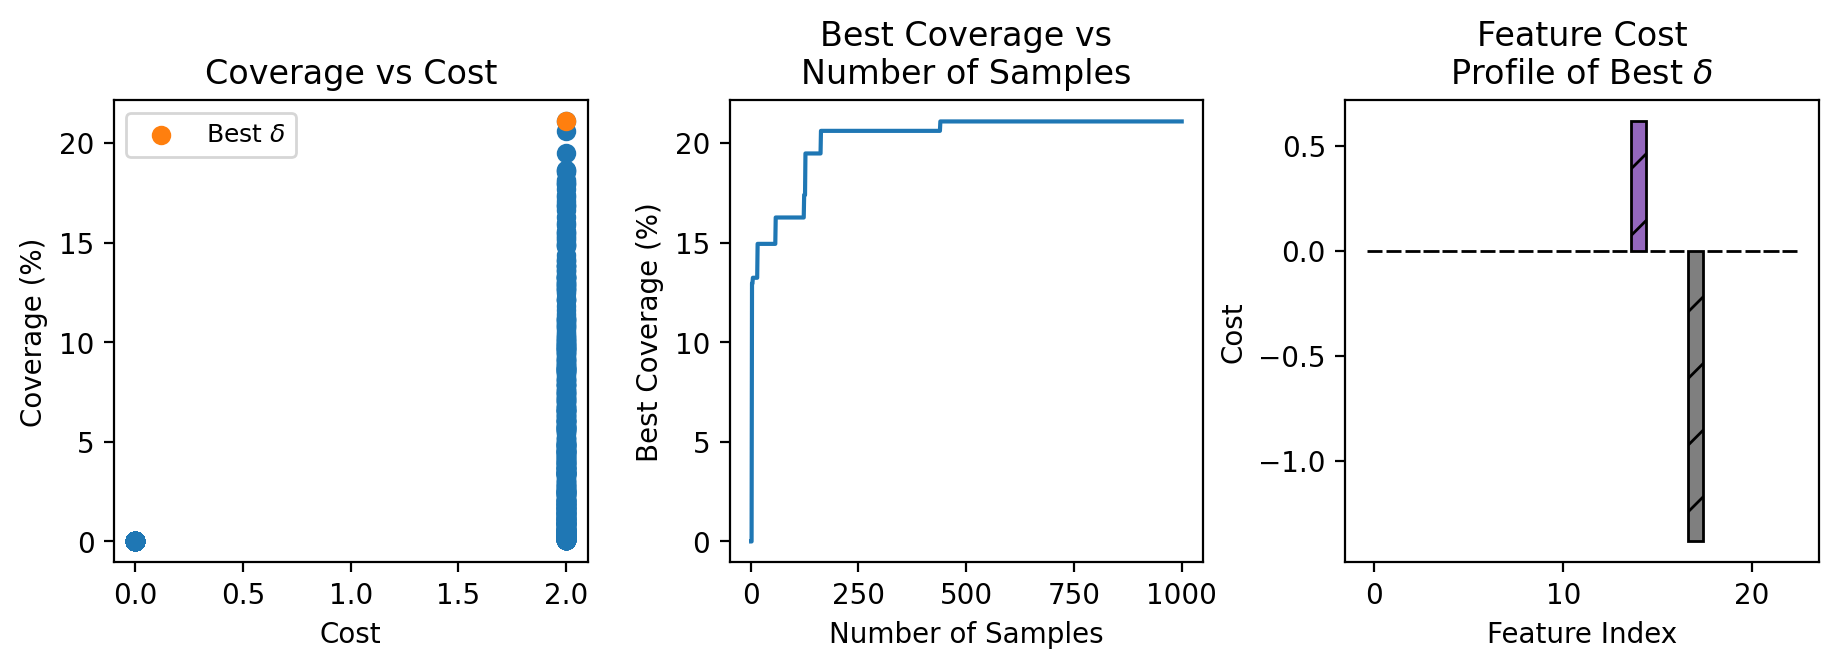

In [18]:
globe_ce.sample(
    n_sample=1000,
    magnitude=2,
    sparsity_power=1,  # magnitude is the fixed cost sampled at
    idxs=None,
    n_features=2,
    disable_tqdm=False,  # 2 random features chosen at each sample, no sparsity smoothing (p=1)
    plot=True,
    seed=0,
    scheme="random",
    dropped_features=[],
)
delta = globe_ce.best_delta  # pick best delta
globe_ce.select_n_deltas(n_div=3)

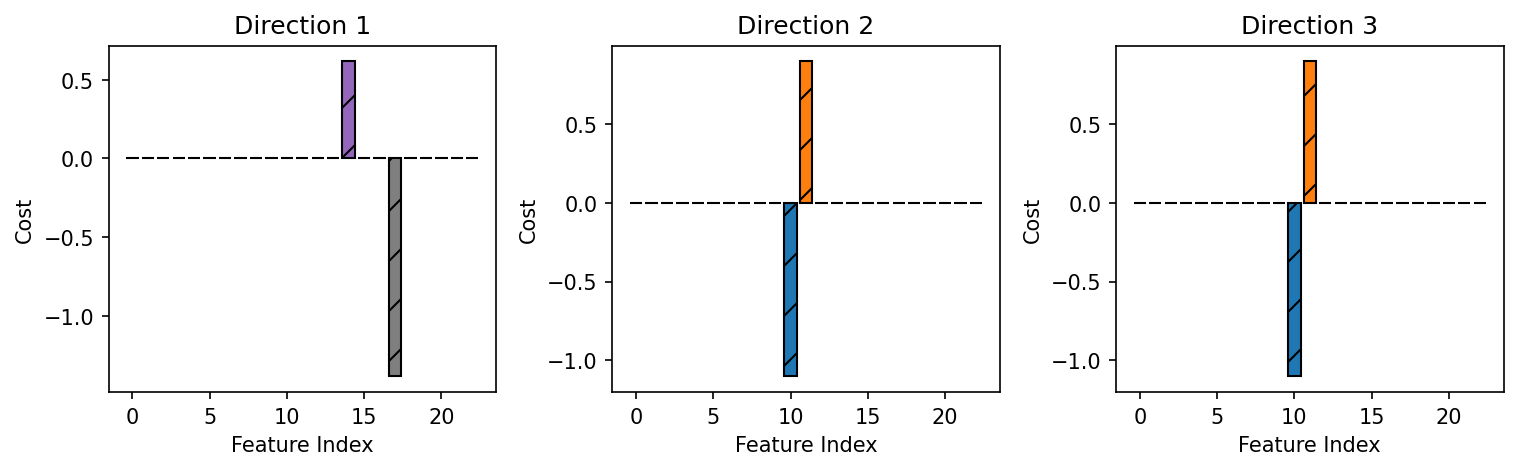

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=globe_ce.deltas_div.shape[0], dpi=150)
fig.set_figwidth(12)
fig.set_figheight(3)
plt.subplots_adjust(wspace=0.3)
for i in range(globe_ce.deltas_div.shape[0]):
    delta_cost = globe_ce.deltas_div[i] * globe_ce.feature_costs_vector
    cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    j, k = 0, 0
    for feature in globe_ce.features_tree:
        if not globe_ce.features_tree[feature]:
            ax[i].bar(
                range(j, j + 1),
                delta_cost[j],
                hatch="/",
                linewidth=1,
                edgecolor="black",
                color=cycle[k % len(cycle)],
            )
            j += 1
            k += 1
        else:
            feature_values = globe_ce.features_tree[feature]
            n_f = len(feature_values)
            ax[2].bar(
                range(j, j + n_f), delta_cost[j : j + n_f], color=cycle[k % len(cycle)]
            )
            j += n_f
            k += 1
    ax[i].set_title(f"Direction {i + 1}")
    ax[i].set_xlabel("Feature Index")
    ax[i].set_ylabel("Cost")
plt.show()